# Lab3 Building your Deep Neural Network: Step by Step
#### Побудова глибокої нейронної мережі крок за кроком


**Позначення**:

* Верхній індекс $\[l]\$ позначає величину, що належить \$l\$-ому шару.
  
   - Приклад: \$a^{\[L]}\$ — активація \$L\$-го шару. \$W^{\[L]}\$ і \$b^{\[L]}\$ — параметри \$L\$-го шару.
* Верхній індекс \$(i)\$ позначає величину, що належить \$i\$-ому прикладу.
  
   - Приклад: \$x^{(i)}\$ — \$i\$-ий тренувальний приклад.
* Нижній індекс \$i\$ позначає \$i\$-ий елемент вектора.
  
   - Приклад: \$a^{\[l]}\_i\$ — \$i\$-ий елемент активацій \$l\$-го шару.


<a name='1'></a>
## 1 - Packages

Спочатку імпортуйте всі пакети, які знадобляться під час цього завдання.

* [numpy](www.numpy.org) — основний пакет для наукових обчислень на Python.
* [matplotlib](http://matplotlib.org) — бібліотека для побудови графіків у Python.
* [h5py](http://www.h5py.org) — поширений пакет для роботи з наборами даних, збережених у форматі H5.
* [PIL](http://www.pythonware.com/products/pil/) та [scipy](https://www.scipy.org/) використовуються тут для перевірки моделі на власному зображенні наприкінці.
* `dnn_utils` надає деякі необхідні функції для цього ноутбука.
* `testCases` містить тестові приклади для перевірки правильності ваших функцій.
* `np.random.seed(1)` використовується для збереження узгодженості викликів випадкових функцій. Це допомагає при оцінюванні вашої роботи. Будь ласка, не змінюйте seed!


In [9]:
### v1.1

In [10]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from testCases import *
from dnn_app_utils_v3 import sigmoid, sigmoid_backward, relu, relu_backward, load_data
from public_tests import *


import time
import scipy
from PIL import Image
from scipy import ndimage

import copy
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 – Огляд

Щоб побудувати свою нейронну мережу, ви реалізуєте кілька "допоміжних функцій". Ось план дій:

* Ініціалізуйте параметри для двошарової мережі та для \$L\$-шарової нейронної мережі.
* Реалізуйте модуль прямого поширення (зображений фіолетовим на рисунку нижче):

  * Завершіть LINEAR-частину кроку прямого поширення шару (що дає \$Z^{\[l]}\$).
  * Функція активації (relu/sigmoid) вже надана для вас.
  * Об'єднайте два попередні кроки в нову функцію прямого поширення \[LINEAR->ACTIVATION].
  * Повторіть \[LINEAR->RELU] для \$L-1\$ шарів (для шарів з 1 до \$L-1\$) і додайте \[LINEAR->SIGMOID] на останньому шарі \$L\$. Це утворює нову функцію `L_model_forward`.
* Обчисліть функцію втрат (loss).
* Реалізуйте модуль зворотного поширення (позначений червоним на рисунку нижче):

  * Завершіть LINEAR-частину кроку зворотного поширення шару.
  * Градієнти функцій активації (relu\_backward/sigmoid\_backward) вже надані для вас.
  * Об’єднайте два попередні кроки в нову функцію зворотного поширення \[LINEAR->ACTIVATION].
  * Повторіть \[LINEAR->RELU] зворотне поширення \$L-1\$ разів і додайте \[LINEAR->SIGMOID] зворотне поширення у новій функції `L_model_backward`.
* Нарешті, оновіть параметри.

<img src="images/final outline.png" style="width:800px;height:500px;">
<caption><center><b>Figure 1</b></center></caption><br>


**Примітка**:

Для кожної функції прямого поширення існує відповідна функція зворотного поширення. Саме тому на кожному кроці прямого модуля ви зберігатимете деякі значення у кеші. Ці кешовані значення будуть корисні для обчислення градієнтів.

У модулі зворотного поширення ви зможете використовувати кеш для обчислення градієнтів.


<a name='3'></a>

## 3 – Ініціалізація

Ви напишете дві допоміжні функції для ініціалізації параметрів вашої моделі. Перша функція буде використовуватися для ініціалізації параметрів двошарової моделі. Друга — узагальнить цей процес для \$L\$-шарової мережі.

<a name='3-1'></a>

### 3.1 – Двошарова нейронна мережа

<a name='ex-1'></a>

### Вправа 1 – `initialize_parameters`

Створіть та ініціалізуйте параметри для двошарової нейронної мережі.

**Інструкції**:

* Структура моделі: *LINEAR → RELU → LINEAR → SIGMOID*.
* Для матриць ваг використовуйте випадкову ініціалізацію: `np.random.randn(d0, d1, ..., dn) * 0.01` з відповідною формою. Документація: [np.random.randn](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html)
* Для векторів зсуву використовуйте ініціалізацію нулями: `np.zeros(shape)`. Документація: [np.zeros](https://numpy.org/doc/stable/reference/generated/numpy.zeros.html)


In [11]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- розмір вхідного шару
    n_h -- розмір прихованого шару
    n_y -- розмір вихідного шару
    
    Returns:
    parameters -- словник Python, що містить параметри:
                    W1 -- матриця ваг розміром (n_h, n_x)
                    b1 -- вектор зсувів розміром (n_h, 1)
                    W2 -- матриця ваг розміром (n_y, n_h)
                    b2 -- вектор зсувів розміром (n_y, 1)
    """
    
    np.random.seed(1)  # фіксуємо зерно генератора випадкових чисел для відтворюваності
    
    # Ініціалізуємо ваги малими випадковими числами, а зсуви нулями
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

In [12]:
print("Test Case 1:\n")
parameters = initialize_parameters(3,2,1)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

initialize_parameters_test_1(initialize_parameters)

print("\033[90m\nTest Case 2:\n")
parameters = initialize_parameters(4,3,2)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

initialize_parameters_test_2(initialize_parameters)

Test Case 1:

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]
 All tests passed.

Test Case 2:

W1 = [[ 0.01624345 -0.00611756 -0.00528172 -0.01072969]
 [ 0.00865408 -0.02301539  0.01744812 -0.00761207]
 [ 0.00319039 -0.0024937   0.01462108 -0.02060141]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[-0.00322417 -0.00384054  0.01133769]
 [-0.01099891 -0.00172428 -0.00877858]]
b2 = [[0.]
 [0.]]
 All tests passed.


***Expected output***
```
Test Case 1:

W1 = [[ 0.01624345 -0.00611756 -0.00528172]
 [-0.01072969  0.00865408 -0.02301539]]
b1 = [[0.]
 [0.]]
W2 = [[ 0.01744812 -0.00761207]]
b2 = [[0.]]
 All tests passed.

Test Case 2:

W1 = [[ 0.01624345 -0.00611756 -0.00528172 -0.01072969]
 [ 0.00865408 -0.02301539  0.01744812 -0.00761207]
 [ 0.00319039 -0.0024937   0.01462108 -0.02060141]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[-0.00322417 -0.00384054  0.01133769]
 [-0.01099891 -0.00172428 -0.00877858]]
b2 = [[0.]
 [0.]]
 All tests passed.
```

<a name='3-2'></a>
### 3.2 – L-шарова нейронна мережа

Ініціалізація для глибшої L-шарової нейронної мережі є складнішою, оскільки існує набагато більше матриць ваг і векторів зміщення. Під час виконання функції `initialize_parameters_deep` ви повинні переконатися, що ваші розмірності узгоджені між кожним шаром. Нагадаємо, що \$n^{\[l]}\$ — це кількість одиниць у шарі \$l\$. Наприклад, якщо розмір вашого вхідного \$X\$ — \$(12288, 209)\$ (де \$m=209\$ прикладів), тоді:


<table style="width:100%">
    <tr>
        <td>  </td> 
        <td> <b>Shape of W</b> </td> 
        <td> <b>Shape of b</b>  </td> 
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td> 
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>  
   <tr>
       <td> <b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
   <tr>
   <tr>
       <td> <b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>
</table>

Remember that when you compute $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{3}  $$


<a name='ex-2'></a>
### Вправа 2 – `initialize_parameters_deep`

Реалізуйте ініціалізацію для L-шарової нейронної мережі.

**Інструкції**:

* Структура моделі: *\[LINEAR → RELU] \$ \times\$ (L-1) → LINEAR → SIGMOID*. Тобто, вона має \$L-1\$ шарів з функцією активації ReLU, за якими йде вихідний шар з функцією активації sigmoid.
* Використовуйте випадкову ініціалізацію для матриць ваг: `np.random.randn(d0, d1, ..., dn) * 0.01`.
* Використовуйте нульову ініціалізацію для векторів зміщення: `np.zeros(shape)`.
* Ви будете зберігати \$n^{\[l]}\$, кількість одиниць у різних шарах, у змінній `layer_dims`. Наприклад, `layer_dims` для минулотижневої моделі класифікації Planar Data було б `[2, 4, 1]`: було два входи, один прихований шар з 4 нейронами та вихідний шар з 1 виходом. Це означає, що форма `W1` — (4,2), `b1` — (4,1), `W2` — (1,4), а `b2` — (1,1). Тепер ви узагальните це для \$L\$ шарів!
* Ось реалізація для \$L=1\$ (однашарова нейронна мережа). Вона має надихнути вас на реалізацію загального випадку (L-шарова нейронна мережа).

```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [13]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- список розмірів кожного шару мережі, наприклад [input_size, hidden1, hidden2, ..., output_size]
    
    Returns:
    parameters -- словник з параметрами:
                    W1, b1, W2, b2, ..., WL, bL
                    Wl -- матриця ваг для шару l розміром (layer_dims[l], layer_dims[l-1])
                    bl -- вектор зсувів для шару l розміром (layer_dims[l], 1)
    """
    
    np.random.seed(3)   # Фіксація генератора випадкових чисел для відтворюваності результатів
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):   # Загальна кількість шарів у мережі (включно з входом і виходом)

        # Ініціалізуємо матрицю ваг випадковими числами, масштабованими на 0.01
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01 
        # Ініціалізуємо вектор зсувів нулями
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
  
        # Перевірка, що розміри ваг та зсувів співпадають з очікуваними
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

In [14]:
print("Test Case 1:\n")
parameters = initialize_parameters_deep([5,4,3])

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

initialize_parameters_deep_test_1(initialize_parameters_deep)

print("\033[90m\nTest Case 2:\n")
parameters = initialize_parameters_deep([4,3,2])

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
initialize_parameters_deep_test_2(initialize_parameters_deep)

Test Case 1:

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]
 All tests passed.

Test Case 2:

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493]
 [-0.00277388 -0.00354759 -0.00082741 -0.00627001]
 [-0.00043818 -0.00477218 -0.01313865  0.00884622]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[ 0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477]]
b2 = [[0.]
 [0.]]
 All tests passed.


***Expected output***
```
Test Case 1:

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493 -0.00277388]
 [-0.00354759 -0.00082741 -0.00627001 -0.00043818 -0.00477218]
 [-0.01313865  0.00884622  0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477  0.00982367 -0.01101068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01185047 -0.0020565   0.01486148  0.00236716]
 [-0.01023785 -0.00712993  0.00625245 -0.00160513]
 [-0.00768836 -0.00230031  0.00745056  0.01976111]]
b2 = [[0.]
 [0.]
 [0.]]
 All tests passed.

Test Case 2:

W1 = [[ 0.01788628  0.0043651   0.00096497 -0.01863493]
 [-0.00277388 -0.00354759 -0.00082741 -0.00627001]
 [-0.00043818 -0.00477218 -0.01313865  0.00884622]]
b1 = [[0.]
 [0.]
 [0.]]
W2 = [[ 0.00881318  0.01709573  0.00050034]
 [-0.00404677 -0.0054536  -0.01546477]]
b2 = [[0.]
 [0.]]
 All tests passed.
```

<a name='4'></a>
## 4 – Модуль прямого поширення

<a name='4-1'></a>

### 4.1 – Лінійне пряме поширення

Тепер, коли ви ініціалізували параметри, можна перейти до модуля прямого поширення. Почніть із реалізації базових функцій, які ви зможете повторно використовувати пізніше при побудові моделі. Ви реалізуєте три функції в такому порядку:

* **LINEAR**
* **LINEAR → ACTIVATION**, де ACTIVATION буде або ReLU, або Sigmoid
* **\[LINEAR → RELU] × (L–1) → LINEAR → SIGMOID** (вся модель)

Модуль лінійного прямого поширення (векторизований для всіх прикладів) обчислює такі рівняння:


$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

де $A^{[0]} = X$. 

<a name='ex-3'></a>
### Вправа 3 – `linear_forward`

Реалізуйте лінійну частину прямого поширення.

**Нагадування**:
Математичне представлення цього кроку:
$Z^{[l]} = W^{[l]}A^{[l-1]} + b^{[l]}$
Також може бути корисною функція `np.dot()`. Якщо розміри не збігаються, спробуйте вивести `W.shape` для діагностики.


In [15]:
def linear_forward(A, W, b):
    """
    Реалізує лінійну частину прямого проходження шару.

    Arguments:
    A -- активації з попереднього шару (або вхідні дані), розмір (розмір попереднього шару, кількість прикладів)
    W -- матриця ваг, розмір (розмір поточного шару, розмір попереднього шару)
    b -- вектор зсувів, розмір (розмір поточного шару, 1)

    Returns:
    Z -- вхід для функції активації (лінійна комбінація), також зветься параметром до активації
    cache -- кортеж (A, W, b), який зберігаємо для зручності при зворотному проходженні (backward propagation)
    """
    
    # Обчислюємо лінійну комбінацію: Z = W * A + b
    Z = np.dot(W, A) + b

    cache = (A, W, b)
    
    return Z, cache

In [16]:
t_A, t_W, t_b = linear_forward_test_case()
t_Z, t_linear_cache = linear_forward(t_A, t_W, t_b)
print("Z = " + str(t_Z))

linear_forward_test(linear_forward)

Z = [[ 3.26295337 -1.23429987]]
 All tests passed.


***Expected output***
```
Z = [[ 3.26295337 -1.23429987]]
```

<a name='4-2'></a>

### 4.2 – Лінійно-активаційне пряме поширення

У цьому ноутбуці ви використовуватимете дві функції активації:

* **Sigmoid**:
  $\sigma(Z) = \sigma(WA + b) = \frac{1}{1 + e^{-(WA + b)}}$
  Вам уже надано функцію `sigmoid`, яка повертає **два** елементи: значення активації "`A`" та "`cache`", що містить "`Z`" (його буде використано у відповідній зворотній функції). Використовувати її можна так:

  ```python
  A, activation_cache = sigmoid(Z)
  ```

* **ReLU**:
  Математична формула для ReLU:
  $A = \text{RELU}(Z) = \max(0, Z)$
  Вам також надано функцію `relu`, яка повертає **два** елементи: значення активації "`A`" і "`cache`", що містить "`Z`" (його буде передано у відповідну зворотну функцію). Використовувати її можна так:

  ```python
  A, activation_cache = relu(Z)
  ```


Для зручності ви об’єднаєте дві функції (Лінійна та Активаційна) в одну функцію (LINEAR->ACTIVATION). Тобто реалізуєте функцію, яка виконує лінійний крок вперед, а потім крок активації.

<a name='ex-4'></a>

### Вправа 4 – `linear_activation_forward`

Реалізуйте пряме поширення шару *LINEAR->ACTIVATION*. Математичне відношення:
$A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} + b^{[l]})$
де активація \$g\$ може бути `sigmoid()` або `relu()`. Використайте функцію `linear_forward()` та відповідну функцію активації.


In [17]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Реалізує пряме проходження для шару: лінійна операція + функція активації

    Arguments:
    A_prev -- активації з попереднього шару (або вхідні дані), розмір (розмір попереднього шару, кількість прикладів)
    W -- матриця ваг поточного шару, розмір (розмір поточного шару, розмір попереднього шару)
    b -- вектор зсувів поточного шару, розмір (розмір поточного шару, 1)
    activation -- тип функції активації: "sigmoid" або "relu"

    Returns:
    A -- активації після застосування функції активації (пост-активаційне значення)
    cache -- кортеж, який містить два кеші: лінійний (linear_cache) та активаційний (activation_cache)
             для подальшого використання у зворотному проходженні
    """
    
    if activation == "sigmoid":
      
        Z, linear_cache = linear_forward(A_prev, W, b)  # Лінійний крок
        A, activation_cache = sigmoid(Z)                # Застосування сигмоїдної активації

    
    elif activation == "relu":
        
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)            # Застосування ReLU активації
 
    cache = (linear_cache, activation_cache)   # Зберігаємо обидва кеші для backward propagation

    return A, cache

In [18]:
t_A_prev, t_W, t_b = linear_activation_forward_test_case()

t_A, t_linear_activation_cache = linear_activation_forward(t_A_prev, t_W, t_b, activation = "sigmoid")
print("With sigmoid: A = " + str(t_A))

t_A, t_linear_activation_cache = linear_activation_forward(t_A_prev, t_W, t_b, activation = "relu")
print("With ReLU: A = " + str(t_A))

linear_activation_forward_test(linear_activation_forward)

With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]
 All tests passed.


***Expected output***
```
With sigmoid: A = [[0.96890023 0.11013289]]
With ReLU: A = [[3.43896131 0.        ]]
```

**Примітка**: У глибинному навчанні обчислення "\[LINEAR->ACTIVATION]" вважається одним шаром нейронної мережі, а не двома шарами.


<a name='4-3'></a>
### 4.3 – Модель з L шарами

Для ще більшої зручності при реалізації \$L\$-шарової нейронної мережі вам потрібна функція, яка повторює попередню (`linear_activation_forward` з RELU) \$L-1\$ разів, а потім виконує один виклик `linear_activation_forward` з SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

<a name='ex-5'></a>
### Вправа 5 – `L_model_forward`

Реалізуйте пряме поширення описаної вище моделі.

**Інструкції**: У наведеному нижче коді змінна `AL` позначатиме
$A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$
(Іноді це також називають `Yhat`, тобто \$\hat{Y}\$.)

**Підказки**:

* Використовуйте функції, які ви написали раніше
* Використайте цикл `for`, щоб повторити \[LINEAR->RELU] \$(L-1)\$ разів
* Не забувайте зберігати кеші в списку `caches`. Щоб додати нове значення `c` у список, використовуйте `list.append(c)`


In [19]:
def L_model_forward(X, parameters):
    """
    Реалізує пряме проходження для мережі з L шарів:
    [LINEAR->RELU]*(L-1) -> LINEAR->SIGMOID
    
    Arguments:
    X -- вхідні дані, numpy масив розміру (кількість ознак, кількість прикладів)
    parameters -- словник параметрів (вивід функції initialize_parameters_deep)
    
    Returns:
    AL -- активації останнього шару (вихід мережі)
    caches -- список кешів, що містить кеші для кожного шару (для backward propagation)
    """

    caches = []                  # список для збереження кешів
    A = X                        # спочатку активації — це вхідні дані
    L = len(parameters) // 2     # кількість шарів у мережі (по 2 параметри на шар: W і b)
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
       
        A_prev = A  # активації з попереднього шару
        # Викликаємо forward для поточного шару з активацією ReLU
        A, cache = linear_activation_forward(A_prev, 
                                           parameters['W' + str(l)], 
                                           parameters['b' + str(l)], 
                                           activation="relu")
        caches.append(cache)

    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    # Пряме проходження для останнього шару з активацією сигмоїд (для класифікації)
    AL, cache = linear_activation_forward(A, 
                                        parameters['W' + str(L)], 
                                        parameters['b' + str(L)], 
                                        activation="sigmoid")
    caches.append(cache)

          
    return AL, caches

In [20]:
t_X, t_parameters = L_model_forward_test_case_2hidden()
t_AL, t_caches = L_model_forward(t_X, t_parameters)

print("AL = " + str(t_AL))

L_model_forward_test(L_model_forward)

AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
 All tests passed.


***Expected output***
```
AL = [[0.03921668 0.70498921 0.19734387 0.04728177]]
```

**Чудово!** Ви реалізували повне пряме поширення, яке приймає вхідні дані X і видає вектор рядка \$A^{\[L]}\$, що містить ваші передбачення. Воно також зберігає всі проміжні значення у "caches". Використовуючи \$A^{\[L]}\$, ви можете обчислити вартість (cost) ваших передбачень.


<a name='5'></a>

## 5 – Функція вартості

Тепер ви можете реалізувати пряме і зворотне поширення! Потрібно обчислити вартість, щоб перевірити, чи справді ваша модель навчається.

<a name='ex-6'></a>

### Вправа 6 – `compute_cost`

Обчисліть крос-ентропійну вартість \$J\$, використовуючи таку формулу: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [12]:
def compute_cost(AL, Y):
    """
    Обчислює функцію вартості (cost function) за формулою крос-ентропії.

    Arguments:
    AL -- вектор ймовірностей, отриманий від мережі (передбачення), розмір (1, кількість прикладів)
    Y -- вектор істинних міток (0 або 1), розмір (1, кількість прикладів)

    Returns:
    cost -- значення крос-ентропійних втрат (скаляр)
    """
    
    m = Y.shape[1]   # кількість прикладів

    # Compute loss from aL and y.
    # Обчислення середньої крос-ентропійної втрати по всіх прикладах
    cost = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))

    
    cost = np.squeeze(cost)       # перетворення shape (1,) на скаляр, якщо потрібно
    
    
    return cost

In [13]:
t_Y, t_AL = compute_cost_test_case()
t_cost = compute_cost(t_AL, t_Y)

print("Cost: " + str(t_cost))

compute_cost_test(compute_cost)

Cost: 0.2797765635793422
 All tests passed.


**Expected Output**:

<table>
    <tr>
        <td><b>cost</b> </td>
    <td> 0.2797765635793422</td> 
    </tr>
</table>

<a name='6'></a>
## 6 – Модуль зворотного поширення

Так само, як і для прямого поширення, ви реалізуєте допоміжні функції для зворотного поширення. Пам’ятайте, що зворотне поширення використовується для обчислення градієнта функції втрат щодо параметрів.

**Reminder**: 
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center><font color='purple'><b>Figure 3</b>: Пряме та зворотне поширення для LINEAR->RELU->LINEAR->SIGMOID <i>Фіолетові блоки позначають пряме поширення, а червоні — зворотне поширення.</i> </font></center></caption>


<!-- 
For those of you who are experts in calculus (which you don't need to be to do this assignment!), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

Тепер, аналогічно до прямого поширення, ви реалізуєте зворотне поширення у три кроки:

1. Лінійне зворотне поширення (LINEAR backward)
2. Зворотне поширення для LINEAR -> ACTIVATION, де ACTIVATION обчислює похідну функції активації — ReLU або sigmoid
3. Зворотне поширення для всієї моделі: \[LINEAR -> RELU] × (L-1) -> LINEAR -> SIGMOID backward

Для наступної вправи вам потрібно пам’ятати, що:

* `b` — це матриця (np.ndarray) з 1 стовпцем і n рядками, наприклад:

  ```python
  b = [[1.0], [2.0]]
  ```
  (пам’ятайте, що `b` є константою)
* `np.sum` виконує сумування елементів масиву ndarray
* `axis=1` або `axis=0` вказують, чи сумування виконується по рядках, чи по стовпцях відповідно
* `keepdims` вказує, чи зберігати початкові розміри матриці після сумування
* Ось приклад для прояснення:


In [21]:
A = np.array([[1, 2], [3, 4]])

print('axis=1 and keepdims=True')
print(np.sum(A, axis=1, keepdims=True))
print('axis=1 and keepdims=False')
print(np.sum(A, axis=1, keepdims=False))
print('axis=0 and keepdims=True')
print(np.sum(A, axis=0, keepdims=True))
print('axis=0 and keepdims=False')
print(np.sum(A, axis=0, keepdims=False))

axis=1 and keepdims=True
[[3]
 [7]]
axis=1 and keepdims=False
[3 7]
axis=0 and keepdims=True
[[4 6]]
axis=0 and keepdims=False
[4 6]


<a name='6-1'></a>
### 6.1 – Лінійне зворотне поширення

Для шару \$l\$ лінійна частина виглядає так:
$Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$
(після чого застосовується функція активації).

Припустимо, що ви вже обчислили похідну $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. You want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<img src="images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center><font color='purple'><b>Figure 4</b></font></center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Here are the formulas you need:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

<a name='ex-7'></a>
### Вправа 7 – `linear_backward`

Використайте наведені вище три формули для реалізації функції `linear_backward()`.

**Підказка**:

* У NumPy транспонувати масив `A` можна за допомогою `A.T` або `A.transpose()`

In [22]:
def linear_backward(dZ, cache):
    """
    Реалізує лінійну частину зворотного проходження для одного шару (шар l)

    Arguments:
    dZ -- градієнт вартості по відношенню до лінійного виходу шару l (shape як у Z)
    cache -- кортеж (A_prev, W, b), отриманий під час прямого проходження цього шару

    Returns:
    dA_prev -- градієнт вартості по відношенню до активацій попереднього шару (l-1), має форму A_prev
    dW -- градієнт вартості по відношенню до ваг W шару l, має форму W
    db -- градієнт вартості по відношенню до вектору зсувів b шару l, має форму b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    # Обчислюємо градієнти:
    # dW - середній по всіх прикладах добуток dZ на активації попереднього шару
    dW = (1/m) * np.dot(dZ, A_prev.T)

    # db - середній по всіх прикладах сумарний градієнт по bias (зберігаємо розмірність)
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True)

    
    # dA_prev - градієнт по активаціях попереднього шару, щоб поширити назад
    dA_prev = np.dot(W.T, dZ)

    
    return dA_prev, dW, db

In [23]:
t_dZ, t_linear_cache = linear_backward_test_case()
t_dA_prev, t_dW, t_db = linear_backward(t_dZ, t_linear_cache)

print("dA_prev: " + str(t_dA_prev))
print("dW: " + str(t_dW))
print("db: " + str(t_db))

linear_backward_test(linear_backward)

dA_prev: [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW: [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db: [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]
 All tests passed.


**Expected Output**:
```
dA_prev: [[-1.15171336  0.06718465 -0.3204696   2.09812712]
 [ 0.60345879 -3.72508701  5.81700741 -3.84326836]
 [-0.4319552  -1.30987417  1.72354705  0.05070578]
 [-0.38981415  0.60811244 -1.25938424  1.47191593]
 [-2.52214926  2.67882552 -0.67947465  1.48119548]]
dW: [[ 0.07313866 -0.0976715  -0.87585828  0.73763362  0.00785716]
 [ 0.85508818  0.37530413 -0.59912655  0.71278189 -0.58931808]
 [ 0.97913304 -0.24376494 -0.08839671  0.55151192 -0.10290907]]
db: [[-0.14713786]
 [-0.11313155]
 [-0.13209101]]
 ```

<a name='6-2'></a>

### 6.2 – Лінійно-активаційне зворотне поширення

Далі ви створите функцію, що об’єднує дві допоміжні функції: **`linear_backward`** та крок зворотного поширення для активації — **`linear_activation_backward`**.

Для допомоги в реалізації `linear_activation_backward` вам надано дві функції зворотного поширення:

* **`sigmoid_backward`**: реалізує зворотне поширення для SIGMOID. Викликати її можна так:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

* **`relu_backward`**: реалізує зворотне поширення для RELU. Викликати її можна так:

```python
dZ = relu_backward(dA, activation_cache)
```

Якщо \$g(.)\$ — функція активації,
то `sigmoid_backward` і `relu_backward` обчислюють:
$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$

<a name='ex-8'></a>

### Вправа 8 – `linear_activation_backward`

Реалізуйте зворотне поширення для шару *LINEAR->ACTIVATION*.


In [24]:
def linear_activation_backward(dA, cache, activation):
    """
    Реалізує зворотнє поширення для шару виду LINEAR->ACTIVATION
    
    Arguments:
    dA -- градієнт вартості по відношенню до активації поточного шару l
    cache -- кортеж (linear_cache, activation_cache), збережений під час прямого проходження
    activation -- тип активації у цьому шарі: "sigmoid" або "relu"
    
    Returns:
    dA_prev -- градієнт вартості по відношенню до активації попереднього шару (l-1)
    dW -- градієнт вартості по відношенню до ваг W шару l
    db -- градієнт вартості по відношенню до bias b шару l
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        # Обчислюємо dZ через похідну ReLU
        dZ = relu_backward(dA, activation_cache)
        # Потім передаємо dZ у лінійний backward для обчислення градієнтів параметрів
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

        
    elif activation == "sigmoid":
        # Обчислюємо dZ через похідну сигмоїди
        dZ = sigmoid_backward(dA, activation_cache)
        # Обчислюємо градієнти параметрів
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [25]:
t_dAL, t_linear_activation_cache = linear_activation_backward_test_case()

t_dA_prev, t_dW, t_db = linear_activation_backward(t_dAL, t_linear_activation_cache, activation = "sigmoid")
print("With sigmoid: dA_prev = " + str(t_dA_prev))
print("With sigmoid: dW = " + str(t_dW))
print("With sigmoid: db = " + str(t_db))

t_dA_prev, t_dW, t_db = linear_activation_backward(t_dAL, t_linear_activation_cache, activation = "relu")
print("With relu: dA_prev = " + str(t_dA_prev))
print("With relu: dW = " + str(t_dW))
print("With relu: db = " + str(t_db))

linear_activation_backward_test(linear_activation_backward)

With sigmoid: dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
With sigmoid: dW = [[ 0.10266786  0.09778551 -0.01968084]]
With sigmoid: db = [[-0.05729622]]
With relu: dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
With relu: dW = [[ 0.44513824  0.37371418 -0.10478989]]
With relu: db = [[-0.20837892]]
 All tests passed.


**Expected output:**

```
With sigmoid: dA_prev = [[ 0.11017994  0.01105339]
 [ 0.09466817  0.00949723]
 [-0.05743092 -0.00576154]]
With sigmoid: dW = [[ 0.10266786  0.09778551 -0.01968084]]
With sigmoid: db = [[-0.05729622]]
With relu: dA_prev = [[ 0.44090989  0.        ]
 [ 0.37883606  0.        ]
 [-0.2298228   0.        ]]
With relu: dW = [[ 0.44513824  0.37371418 -0.10478989]]
With relu: db = [[-0.20837892]]
```

<a name='6-3'></a>
### 6.3 – Зворотне поширення для L-шарової моделі

Тепер ви реалізуєте функцію зворотного поширення для всієї мережі!

Нагадаємо, що під час реалізації функції `L_model_forward` на кожній ітерації ви зберігали кеш, який містить (X, W, b та Z). У модулі зворотного поширення ви будете використовувати ці змінні для обчислення градієнтів. Тому у функції `L_model_backward` ви ітеруватиметесь по всіх прихованих шарах у зворотному напрямку, починаючи з шару \$L\$. На кожному кроці ви будете використовувати кешовані значення для шару \$l\$, щоб виконати зворотне поширення через цей шар. На рисунку 5 нижче показано хід зворотного проходу.


<img src="images/mn_backward.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Ініціалізація зворотного поширення**:

Щоб виконати зворотне поширення в цій мережі, вам потрібно знати, що вихід:
$A^{[L]} = \sigma(Z^{[L]}).$
Ваш код має обчислити `dAL` — похідну втрат за \$A^{\[L]}\$:

```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))  # похідна функції вартості по AL
```

Потім цей градієнт після активації `dAL` можна передати далі назад. Як показано на рисунку 5, ви можете подати `dAL` у функцію зворотного поширення для LINEAR->SIGMOID, яку ви реалізували (вона використає кешовані значення, збережені у функції `L_model_forward`).

Після цього вам потрібно буде за допомогою циклу `for` пройтися по всіх інших шарах, використовуючи функцію зворотного поширення для LINEAR->RELU. Кожен `dA`, `dW` та `db` слід зберігати у словнику `grads`. Для цього використовуйте формулу:

$grads["dW" + str(l)] = dW^{[l]} \tag{15}$

Наприклад, для \$l=3\$ це зберігає \$dW^{\[3]}\$ у `grads["dW3"]`.

<a name='ex-9'></a>

### Вправа 9 – `L_model_backward`

Реалізуйте зворотне поширення для моделі *\[LINEAR->RELU] × (L-1) -> LINEAR -> SIGMOID*.


In [26]:
def L_model_backward(AL, Y, caches):
    """
    Реалізує зворотнє поширення для мережі з (L-1) шарами RELU + 1 вихідним шаром SIGMOID.
    
    Arguments:
    AL -- вектор ймовірностей з виходу мережі (пряме проходження)
    Y -- вектор правильних міток (0 або 1)
    caches -- список кешів з усіх шарів (лінійні + активації)
    
    Returns:
    grads -- словник з градієнтами для всіх параметрів мережі:
             grads["dA" + str(l)] -- градієнт активації шару l
             grads["dW" + str(l)] -- градієнт ваг шару l
             grads["db" + str(l)] -- градієнт байаса шару l
    """
    grads = {}   
    L = len(caches)   # кількість шарів 
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # приводимо Y до такої ж форми, що й AL
    
    # Ініціалізуємо градієнт dAL — похідну функції вартості по AL (вихід мережі)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    # Застосовуємо backward propagation для останнього шару (SIGMOID)
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    
    # Цикл по шарах від L-2 до 0 для backward propagation RELU шарів
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        #(approx. 5 lines)
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp


    return grads

In [27]:
t_AL, t_Y_assess, t_caches = L_model_backward_test_case()
grads = L_model_backward(t_AL, t_Y_assess, t_caches)

print("dA0 = " + str(grads['dA0']))
print("dA1 = " + str(grads['dA1']))
print("dW1 = " + str(grads['dW1']))
print("dW2 = " + str(grads['dW2']))
print("db1 = " + str(grads['db1']))
print("db2 = " + str(grads['db2']))

L_model_backward_test(L_model_backward)

dA0 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
dW2 = [[-0.39202432 -0.13325855 -0.04601089]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
db2 = [[0.15187861]]
 All tests passed.


**Expected output:**

```
dA0 = [[ 0.          0.52257901]
 [ 0.         -0.3269206 ]
 [ 0.         -0.32070404]
 [ 0.         -0.74079187]]
dA1 = [[ 0.12913162 -0.44014127]
 [-0.14175655  0.48317296]
 [ 0.01663708 -0.05670698]]
dW1 = [[0.41010002 0.07807203 0.13798444 0.10502167]
 [0.         0.         0.         0.        ]
 [0.05283652 0.01005865 0.01777766 0.0135308 ]]
dW2 = [[-0.39202432 -0.13325855 -0.04601089]]
db1 = [[-0.22007063]
 [ 0.        ]
 [-0.02835349]]
db2 = [[0.15187861]]
```

<a name='6-4'></a>
### 6.4 – Оновлення параметрів

У цьому розділі ви оновите параметри моделі за допомогою градієнтного спуску:


$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

де \$\alpha\$ — швидкість навчання (learning rate).

Після обчислення оновлених параметрів збережіть їх у словнику `parameters`.


<a name='ex-10'></a>
### Вправа 10 – update\_parameters

Реалізуйте функцію `update_parameters()`, яка оновлює параметри за допомогою градієнтного спуску.

**Інструкції**:
Оновлюйте параметри, застосовуючи градієнтний спуск на кожному шарі. $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$. 

In [28]:
def update_parameters(params, grads, learning_rate):
    """
    Оновлення параметрів нейронної мережі за допомогою градієнтного спуску
    
    Arguments:
    params -- словник з параметрами мережі (ваги і біаси)
    grads -- словник з обчисленими градієнтами (з функції backward propagation)
    
    Returns:
    parameters -- словник з оновленими параметрами після кроку градієнтного спуску
    """
    parameters = copy.deepcopy(params)   # робимо копію параметрів, щоб не змінювати оригінал
    L = len(parameters) // 2             # визначаємо кількість шарів

    # Update rule for each parameter. Use a for loop.
    # Для кожного шару оновлюємо W і b, віднімаючи градієнт помножений на learning_rate
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
 
    return parameters

In [29]:
t_parameters, grads = update_parameters_test_case()
t_parameters = update_parameters(t_parameters, grads, 0.1)

print ("W1 = "+ str(t_parameters["W1"]))
print ("b1 = "+ str(t_parameters["b1"]))
print ("W2 = "+ str(t_parameters["W2"]))
print ("b2 = "+ str(t_parameters["b2"]))

update_parameters_test(update_parameters)

W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]
 All tests passed.


**Expected output:**

```
W1 = [[-0.59562069 -0.09991781 -2.14584584  1.82662008]
 [-1.76569676 -0.80627147  0.51115557 -1.18258802]
 [-1.0535704  -0.86128581  0.68284052  2.20374577]]
b1 = [[-0.04659241]
 [-1.28888275]
 [ 0.53405496]]
W2 = [[-0.55569196  0.0354055   1.32964895]]
b2 = [[-0.84610769]]
```

<a name='2'></a>
## 7 – Завантаження та обробка набору даних

Ви будете використовувати той самий набір даних "Кіт проти не-кота", що й у прикладі "Логістична регресія як нейронна мережа". Модель, яку ви створили тоді, показала 70% точності на тесті у класифікації зображень кота та не-кота. Сподіваємось, ваша нова модель працюватиме ще краще!

**Завдання**: Вам надано набір даних ("data.h5"), що містить:

* навчальний набір з `m_train` зображень, позначених як кіт (1) або не-кот (0)
* тестовий набір з `m_test` зображень, позначених як кіт та не-кот
* кожне зображення має розмір (num\_px, num\_px, 3), де 3 — це канали RGB

First, import helper functions

In [30]:
from dnn_app_utils_v3 import *


#np.random.seed(1)

Давайте ближче познайомимось із набором даних. Завантажте дані, виконавши наведений нижче код.

In [33]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

Наведений код покаже вам зображення з набору даних. Можете змінювати індекс і повторно запускати цей блок, щоб переглянути інші зображення.

y = 0. It's a non-cat picture.


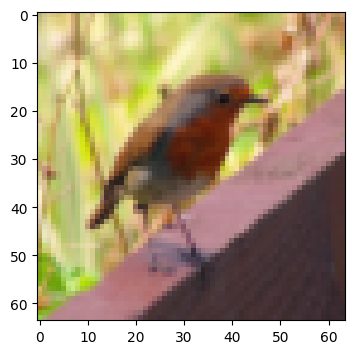

In [39]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [41]:
# Ознайомтеся зі своїм набором даних
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Як зазвичай, перед подачею зображень у мережу їх змінюють за розміром (reshape) і стандартизують. Код наведено у наступній комірці.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 1</b>: Image to vector conversion.</font></center></caption>

In [42]:
# Змінюємо форму (reshape) тренувальних та тестових прикладів
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Стандартизуємо дані, щоб значення ознак були в межах від 0 до 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Примітка**:
\$12,288\$ дорівнює \$64 \times 64 \times 3\$, що є розміром одного вектора зображення після зміни форми.

## 8 – Архітектура моделі

<a name='3-1'></a>

### 8.1 – 2-шарова нейронна мережа

Тепер, коли ви ознайомилися з набором даних, настав час побудувати глибоку нейронну мережу, щоб розрізняти зображення котів і не котів!

Ви побудуєте дві різні моделі:

* 2-шарову нейронну мережу
* Глибоку нейронну мережу з L шарами

Потім ви порівняєте продуктивність цих моделей і спробуєте різні значення \$L\$.

Давайте розглянемо ці дві архітектури:

<img src="images/2layerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 2</b>: 2-layer neural network. <br> The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.</font></center></caption>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is a (64,64,3) image which is flattened to a vector of size $(12288,1)$. 
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 12288)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. If it's greater than 0.5, classify it as a cat.

<a name='3-2'></a>
### 8.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center><font color='purple'><b>Figure 3</b>: L-layer neural network. <br> The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID</font></center></caption>

<u><b>Detailed Architecture of Figure 3</b></u>:
* Вхідним є зображення розміром (64,64,3), яке перетворюється в вектор розміром (12288,1).
* Відповідний вектор $\[x\_0, x\_1, ..., x\_{12287}]^T\$ множиться на матрицю ваг \$W^{\[1]}\$, після чого додається вільний член (зсув) \$b^{\[1]}\$. Результат називається лінійним блоком.
* Далі застосовують функцію активації ReLU до лінійного блоку. Цей процес може повторюватися кілька разів для кожної пари параметрів \$(W^{\[l]}, b^{\[l]})\$ залежно від архітектури моделі.
* Нарешті, застосовується сигмоїдна функція активації до останнього лінійного блоку. Якщо результат більший за 0.5 — класифікуємо як кота.

<a name='3-3'></a>

### 8.3 – Загальна методологія

Як зазвичай, ви будете слідувати методології глибокого навчання для побудови моделі:

1. Ініціалізувати параметри / Визначити гіперпараметри
2. Запустити цикл на num\_iterations:
    a. Пряме поширення (forward propagation)
    b. Обчислити функцію вартості (cost function)
    c. Зворотне поширення (backward propagation)
    d. Оновити параметри (використовуючи parameters і grads із backpropagation)
3. Використати натреновані параметри для прогнозування міток

Тепер вперед — реалізуйте ці дві моделі!


<a name='4'></a>

## 9 - Двошарова нейронна мережа

<a name='ex-1'></a>

### Вправа 11 - two\_layer\_model

Використайте допоміжні функції, які ви реалізували у попередньому завданні, щоб побудувати двошарову нейронну мережу зі структурою: *LINEAR -> RELU -> LINEAR -> SIGMOID*. Функції та їхні вхідні параметри:

```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [43]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [45]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Реалізує двошаровий нейронний мережу: LINEAR->RELU->LINEAR->SIGMOID.

Аргументи:
    X — вхідні дані, форми (n\_x, кількість прикладів)
    Y — вектор справжніх міток (1 — кіт, 0 — не кіт), форми (1, кількість прикладів)
    layers_dims — розміри шарів (n\_x, n\_h, n\_y)
    num_iterations — кількість ітерацій циклу оптимізації
    learning_rate — швидкість навчання для оновлення за градієнтним спуском
    print_cost — якщо встановлено в True, буде виводитись вартість кожні 100 ітерацій

Повертає:
    parameters — словник, що містить W1, W2, b1 та b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # номер прикладу
    (n_x, n_h, n_y) = layers_dims
    
    # Ініціалізуйте словник параметрів, викликавши одну з функцій, яку ви раніше реалізували.
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Отримайте W1, b1, W2 та b2 зі словника параметрів.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # цикл градієнтного спуску

    for i in range(0, num_iterations):

        # Пряме поширення: LINEAR -> RELU -> LINEAR -> SIGMOID. Вхідні дані: "X, W1, b1, W2, b2". Вихідні дані: "A1, cache1, A2, cache2".
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        # Обчислюємо вартість (cost).
        cost = compute_cost(A2, Y)
        
        # Ініціалізація зворотного поширення (backward propagation).
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Зворотне поширення (backward propagation). Вхідні дані: `dA2, cache2, cache1`. Вихідні дані: `dA1, dW2, db2`; також `dA0` (не використовується), `dW1`, `db1`.
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        
        # Встановіть `grads['dW1']` рівним `dW1`, `grads['db1']` рівним `db1`, `grads['dW2']` рівним `dW2`, `grads['db2']` рівним `db2`.
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # оновлюємо параметри
        parameters = update_parameters(parameters, grads, learning_rate)

        # Отримуємо W1, b1, W2, b2 з параметрів (parameters).
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Виводимо вартість (cost) кожні 100 ітерацій.
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [46]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

two_layer_model_test(two_layer_model)

Cost after iteration 1: 0.6926114346158595
Cost after first iteration: 0.693049735659989
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 1: 0.6915746967050506
Cost after iteration 2: 0.6524135179683452
 All tests passed.


**Expected output:**

```
cost after iteration 1 must be around 0.69
```

Добре! Якщо код у попередній комірці працює без помилок, запустіть комірку нижче, щоб навчити модель.

* Вартість (cost) має зменшуватися з кожною ітерацією.
* Виконання 2500 ітерацій може зайняти до 5 хвилин.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433244
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203891
Cost after iteration 900: 0.35807050113237976
Cost after iteration 1000: 0.33942815383664116
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213018
Cost after iteration 1300: 0.24681768210614874
Cost after iteration 1400: 0.19850735037466088
Cost after iteration 1500: 0.17448318112556635
Cost after iteration 1600: 0.17080762978096195
Cost after iteration 1700: 0.11306524562164721
Cost after iteration 1800: 0.09629426845937146
Cost after iteration 1900: 0.08342617959726856
Cost after iteration 2000: 0.07439078704319077
Cost after iteration 2100: 0.0663074

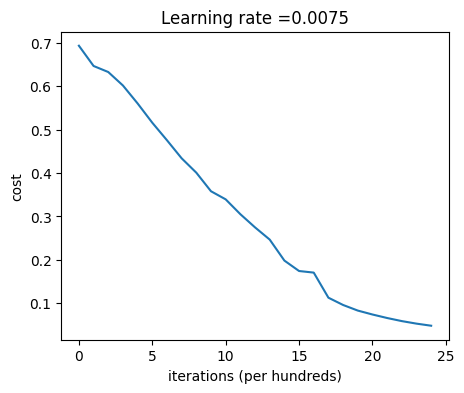

In [47]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)
plot_costs(costs, learning_rate)

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.04421498215868956 </td>
    </tr>
</table>

Чудово! Ви успішно навчили модель. Добре, що ви зробили векторизовану реалізацію — інакше навчання зайняло б у 10 разів більше часу.

Тепер ви можете використати навчені параметри для класифікації зображень з датасету. Щоб побачити ваші передбачення на навчальній та тестовій вибірках, запустіть наступну комірку.


In [48]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Expected Output**:
<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.9999999999999998 </td>
    </tr>
</table>

In [49]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Expected Output**:

<table> 
    <tr>
        <td> <b>Accuracy</b></td>
        <td> 0.72 </td>
    </tr>
</table>

Вітаю! Схоже, ваша 2-шарова нейронна мережа показує кращу якість (72%) у порівнянні з логістичною регресією (70%, завдання з 2-го тижня). Подивимось, чи зможете ви досягти ще кращих результатів з \$L\$-шаровою моделлю.

**Примітка**: Ви можете помітити, що запуск моделі на меншій кількості ітерацій (наприклад, 1500) дає кращу точність на тестовій вибірці. Це називається «рання зупинка» (early stopping), про яку ми дізнаємось пізніше. Рання зупинка допомагає уникнути перенавчання.


<a name='5'></a>
## 10 - L-шарова нейронна мережа

<a name='ex-2'></a>

### Вправа 12 - L\_layer\_model

Використайте допоміжні функції, які ви реалізували раніше, щоб побудувати L-шарову нейронну мережу зі структурою:
*\[LINEAR -> RELU]\$\times\$(L-1) -> LINEAR -> SIGMOID*.

Функції та їхні вхідні параметри такі:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [50]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [51]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
Реалізує L-шарову нейронну мережу: \[ЛІНІЙНИЙ->RELU]\*(L-1)->ЛІНІЙНИЙ->СИГМОЇДА.

```
Аргументи:
X -- вхідні дані, розмірність (n_x, кількість прикладів)
Y -- вектор істинних міток (1 для кота, 0 для не-кота), розмірність (1, кількість прикладів)
layers_dims -- список, що містить розмірність вхідного шару та кожного шару мережі, довжина = кількість шарів + 1
learning_rate -- швидкість навчання для градієнтного спуску
num_iterations -- кількість ітерацій циклу оптимізації
print_cost -- якщо True, виводить вартість (cost) кожні 100 кроків

Повертає:
parameters -- параметри, які навчився модель. Потім їх можна використовувати для прогнозування.
```

"""

    np.random.seed(1)
    costs = []                         # відстежуємо вартість (cost)
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Пряме поширення: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Обчислюємо вартість (cost).
        cost = compute_cost(AL, Y)
    
        # Ініціалізація зворотного поширення (backward propagation).
        grads = L_model_backward(AL, Y, caches)  
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

In [52]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

L_layer_model_test(L_layer_model)

Cost after iteration 0: 0.7717493284237685
Cost after first iteration: 0.7717493284237685
Cost after iteration 1: 0.7070709008912568
Cost after iteration 1: 0.7070709008912568
Cost after iteration 1: 0.7070709008912568
Cost after iteration 2: 0.7063462654190897
 All tests passed.


Якщо ваш код пройшов попередню перевірку, запустіть код нижче, щоб навчити модель із 4 шарами.

* Вартість (cost) має зменшуватись на кожній ітерації.

* Виконання 2500 ітерацій може зайняти до 5 хвилин.

In [53]:
parameters, costs = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.7717493284237685
Cost after iteration 100: 0.6720534400822918
Cost after iteration 200: 0.6482632048575216
Cost after iteration 300: 0.6115068816101354
Cost after iteration 400: 0.5670473268366113
Cost after iteration 500: 0.5401376634547802
Cost after iteration 600: 0.5279299569455271
Cost after iteration 700: 0.4654773771766849
Cost after iteration 800: 0.36912585249592783
Cost after iteration 900: 0.39174697434805333
Cost after iteration 1000: 0.31518698886006147
Cost after iteration 1100: 0.2726998441789384
Cost after iteration 1200: 0.23741853400268118
Cost after iteration 1300: 0.19960120532208628
Cost after iteration 1400: 0.1892630038846329
Cost after iteration 1500: 0.16118854665827767
Cost after iteration 1600: 0.14821389662363324
Cost after iteration 1700: 0.1377748781297294
Cost after iteration 1800: 0.12974017549190134
Cost after iteration 1900: 0.12122535068005211
Cost after iteration 2000: 0.11382060668633719
Cost after iteration 2100: 0.1078392

**Expected Output**:
<table> 
    <tr>
        <td> <b>Cost after iteration 0</b></td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 100</b></td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> <b>...</b></td>
        <td> ... </td>
    </tr>
    <tr>
        <td> <b>Cost after iteration 2499</b></td>
        <td> 0.088439 </td>
    </tr>
</table>

In [54]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


**Expected Output**:

<table>
    <tr>
    <td>
        <b>Train Accuracy</b>
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [55]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Expected Output**:

<table> 
    <tr>
        <td> <b>Test Accuracy</b></td>
        <td> 0.8 </td>
    </tr>
</table>

Вітаю! Схоже, що ваша 4-шарова нейронна мережа має кращу точність (80%) порівняно з 2-шаровою (72%) на тому ж тестовому наборі.

Це досить хороший результат для цього завдання. Молодець!

Пізніше ми зможемо досягти ще вищої точності, систематично підбираючи кращі гіперпараметри: learning\_rate, layers\_dims, num\_iterations тощо.


<a name='6'></a>
##  11 - Results Analysis

Спершу подивіться на деякі зображення, які модель з L шарами класифікувала неправильно. Це допоможе побачити кілька помилково класифікованих зображень.

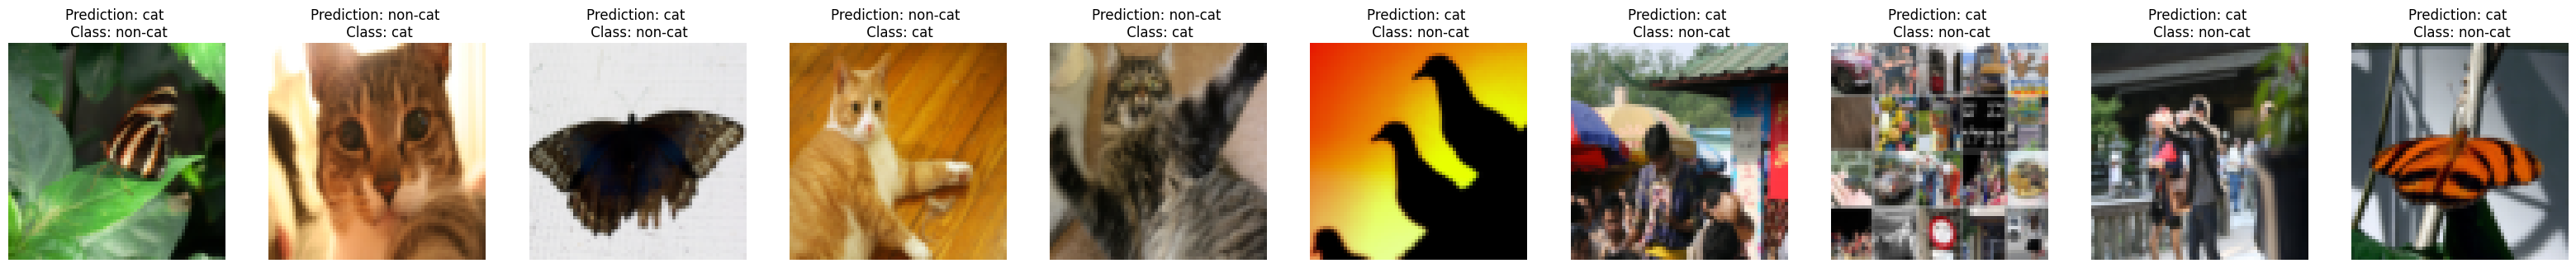

In [56]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Декілька типів зображень, на яких модель зазвичай показує погані результати, включають:**

* Тіло кота в незвичній позі
* Кіт на фоні схожого кольору
* Незвичний колір або порода кота
* Кут зйомки камери
* Яскравість зображення
* Зміна масштабу (кіт дуже великий або маленький на зображенні)


<a name='7'></a>
## 12 - Тестування на власному зображенні

Від цього моменту, якщо бажаєте, ви можете використати власне зображення, щоб перевірити роботу вашої моделі. Для цього виконайте наступні кроки:

1. Натисніть на «File» у верхній панелі цього ноутбука, потім виберіть «Open».
2. Додайте ваше зображення до директорії цього Jupyter Notebook, у папку «images».
3. Змініть назву зображення у наступному коді на вашу.
4. Запустіть код і перевірте, чи алгоритм правильно класифікує (1 = кіт, 0 = не кіт)!


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


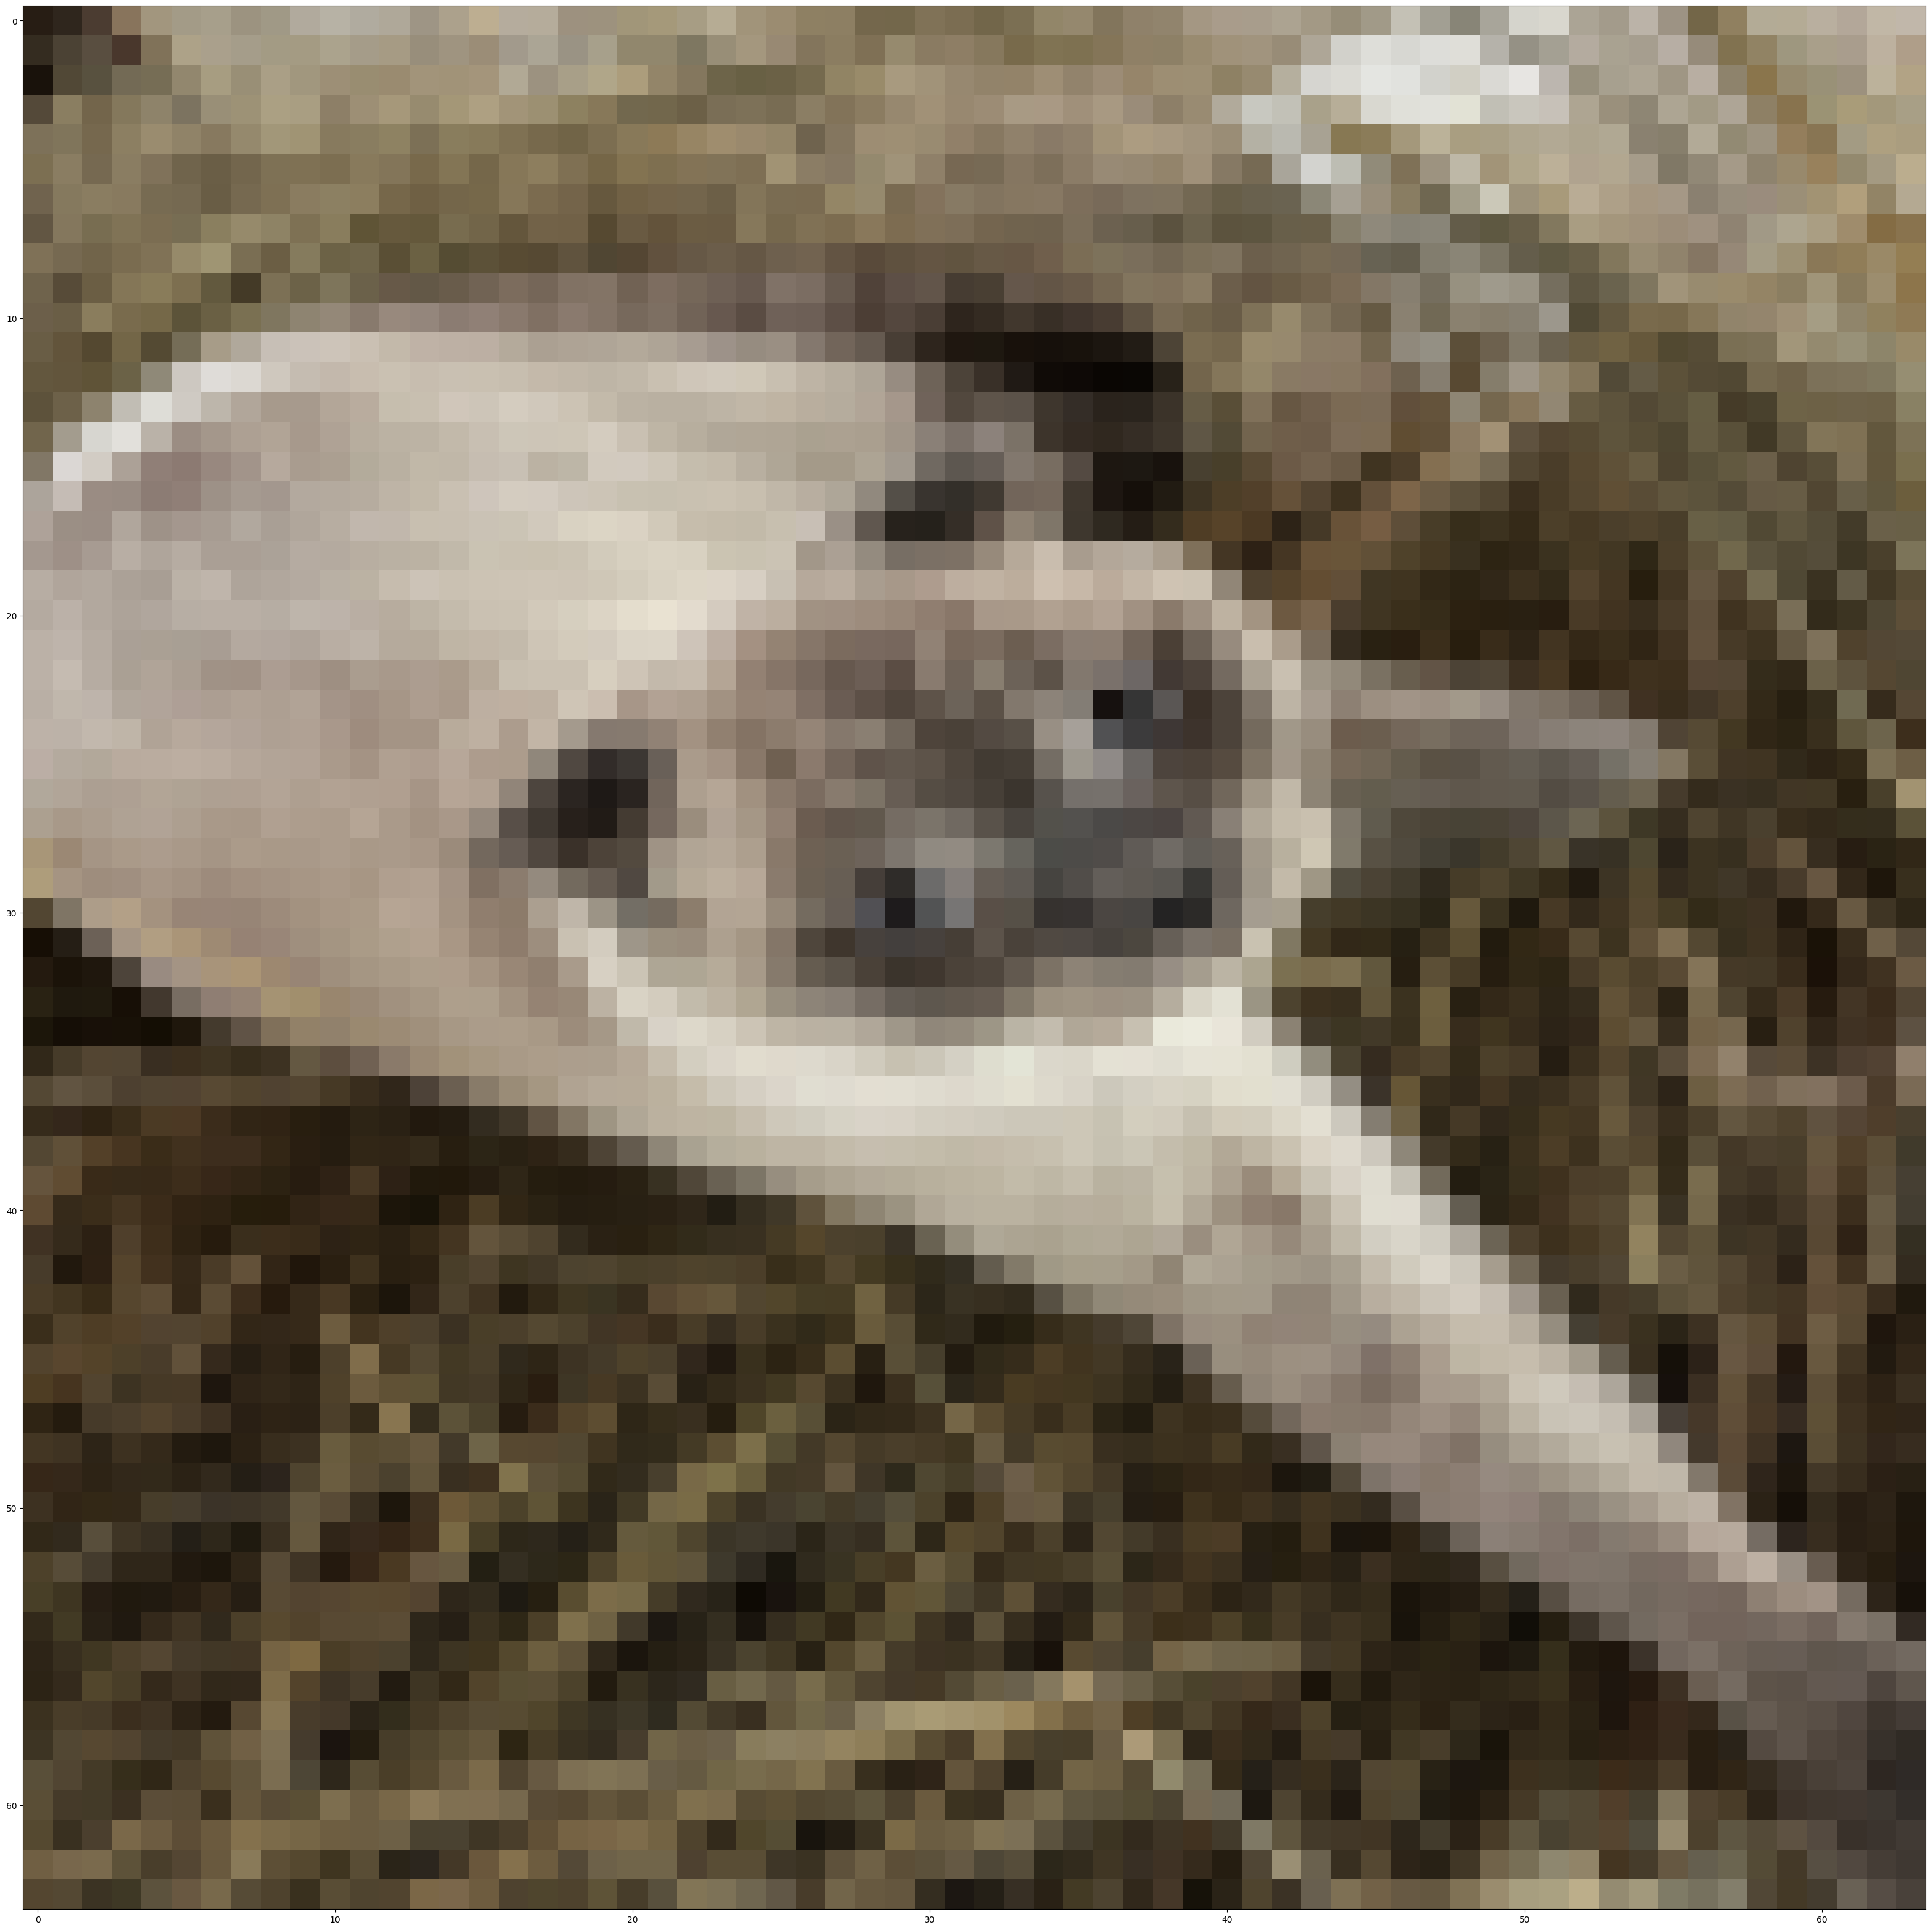

In [64]:
my_image = "cat.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T

my_predicted_image = predict(image, my_label_y, parameters)


print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")